In [1]:
import os
os.chdir("/content/drive/MyDrive/MADE/Project/deap")

In [2]:
#username: evshuranov@itmo.ru
#password: ljli0Nyj

In [3]:
#!wget --user evshuranov@itmo.ru --password ljli0Nyj http://www.eecs.qmul.ac.uk/mmv/datasets/deap/data/metadata_csv.zip

In [4]:
#!wget --user evshuranov@itmo.ru --password ljli0Nyj  "http://www.eecs.qmul.ac.uk/mmv/datasets/deap/data/data_preprocessed_python.zip" 


In [5]:
#!unzip  data_preprocessed_python.zip -d .


In [6]:
#import _pickle as cPickle
#import six
#from six.moves import cPickle as pickle
import pickle
x = pickle.load(open('./data_preprocessed_python/s01.dat', 'rb'), encoding='latin1')

In [7]:
data = x['data']
labels = x['labels']

In [8]:
print(data.shape)

(40, 40, 8064)


In [9]:
print(labels.shape)

(40, 4)


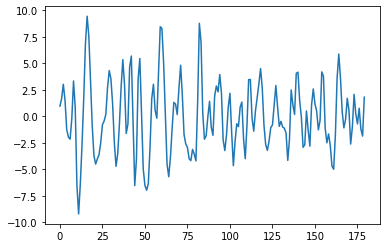

In [10]:
import matplotlib.pyplot as plt
plt.plot(data[0][0][0:180])

In [11]:
import scipy
from  scipy import signal
freq, power = signal.welch(data[0][0], fs=128.0, window='hanning', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

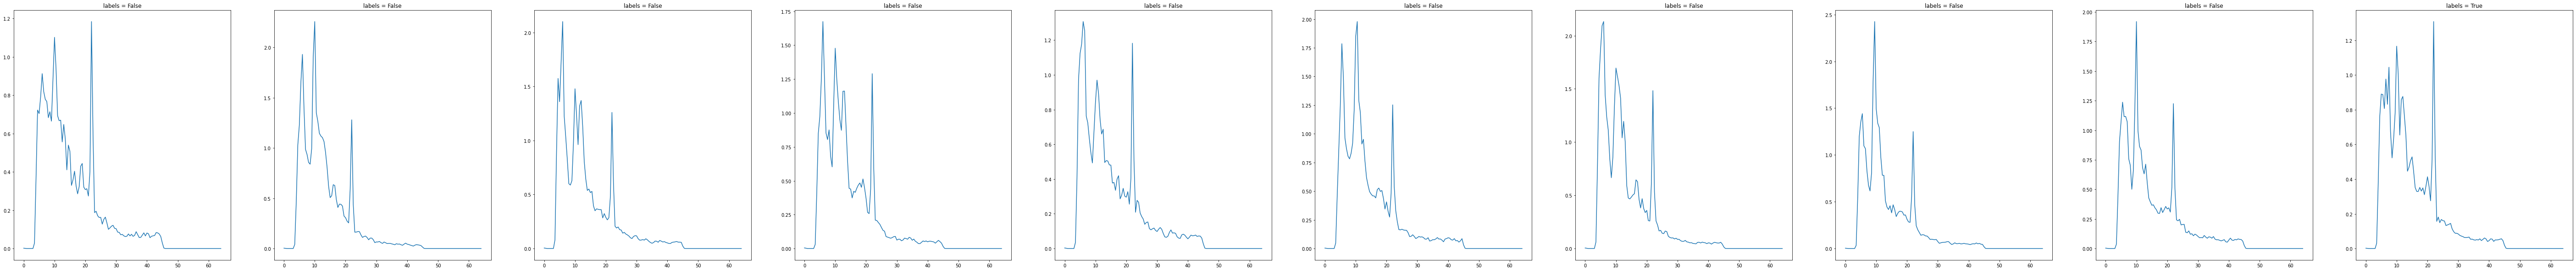

In [12]:
fig, axes = plt.subplots(1,10, figsize = (100, 10))
A = 30
for i in range(0 + A,10 + A):
    freq, power = signal.welch(data[i][0], fs=128.0, window='hanning', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
    axes[i -A].plot(freq, power)
    axes[i - A].set_title(f'labels = {(labels[i][0] > 4.5)}')

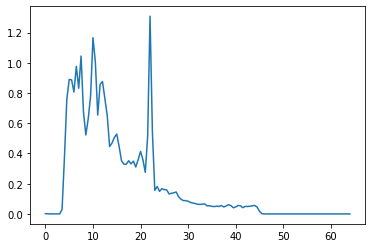

In [13]:
plt.plot(freq, power)

In [14]:
#from scipy.fft import fft, ifft

#pre_stimul = fft(data[0][0][0:128 * 3])

The logarithms of the spectral power from
theta (4-8 Hz), slow alpha (8-10 Hz), alpha (8-12 Hz), beta
(12-30Hz) and gamma (30+ Hz) bands were extracted
from all 32 electrodes as features. In addition to power
spectral features the difference between the spectral
power of all the symmetrical pairs of electrodes on
the right and left hemisphere was extracted to measure
the possible asymmetry in the brain activities due to
emotional stimuli. The total number of EEG features of
a trial for 32 electrodes is 216.

In [15]:
freq_ranges = [range(4,9), range(8,11), range(8,13), range(12, 31), range(30,48)]
pairs_canals = [[1, 17], [2, 18], [3, 20], [4, 21], [5, 22], [6, 23], [7, 25], [8, 26], [9, 27], [10, 28], [11, 29], [12, 30], [12, 31], [13, 32]]

In [16]:
import numpy as np
import scipy
from scipy import stats
freq_resolution = max(freq)/(len(freq) - 1)
max_freq = 128
NVIDEOS = 40
NCANALS = 32
def get_features_whole(data, labels, freq_resolution, max_freq):
  data_for_videos = []
  for id in range(NVIDEOS):
    data_for_one_video = []
    for i in range(NCANALS):
        
        freq, power = scipy.signal.welch(data[id][i], fs=max_freq, window='hanning', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
        #one_canal = []
        powers_temp  = []
        for i, interval in enumerate(freq_ranges):
            ar = np.asarray(interval)
            ar = (ar / freq_resolution).astype(int)
            power_range = power[ar]
            mean_power = (power_range ** 2).sum()/len(power_range)
            data_for_one_video.extend([mean_power])
            powers_temp.append(mean_power)
        for s in range(5):
          for k in range(s):
            data_for_one_video.extend([powers_temp[s]/powers_temp[k]])

            
    for pair in pairs_canals:
        canal_1 = pair[0] - 1
        canal_2 = pair[1] - 1
        temp = np.asarray(data_for_one_video[canal_1 * 4 : canal_1 * 4 + 5]) -  np.asarray(data_for_one_video[canal_2 * 4 : canal_2 * 4 + 5])
        data_for_one_video.extend(temp[[0, 2, 3, 4]].tolist())       
        #data_for_one_video.append(one_canal)    
    for s in range(5 * NCANALS):
      data_for_one_video[s] = np.log(data_for_one_video[s])

    temp = np.asarray(data_for_one_video)
    data_for_videos.append(temp.copy())    
    result = np.asarray(data_for_videos)   
    result = stats.zscore(result)
  return np.asarray(data_for_videos)     



In [17]:
import glob
data = []
labels = []
data_dir = './data_preprocessed_python'
files = glob.glob(os.path.join(data_dir, "*.dat"))

for file_data in files:
    raw_data = pickle.load(open(file_data, 'rb'), encoding='latin1')
    data.append(raw_data['data'])
    labels.append(raw_data['labels'])

In [42]:
import pandas as pd
def get_statistics_for_sub(data, labels):
    indexes = []
    for i in range(NVIDEOS):
      for j in range(NCANALS):
          indexes.append(f'{i}_{j}')

    result = pd.DataFrame(columns = ['mean', 'std', 'min', 'max', 'arousal', 'valence', 'dominance', 'like'], index = indexes)
    #print(result.head())
    for trial in range(len(data)):
       for canal in range(NCANALS):
         result.loc[f"{trial}_{canal}", "mean"]  = data[trial, canal, :].mean()
         result.loc[f"{trial}_{canal}", "std"]  = data[trial, canal, :].std()
         result.loc[f"{trial}_{canal}", "min"]  = data[trial, canal, :].min()
         result.loc[f"{trial}_{canal}", "max"]  = data[trial, canal, :].max()
         result.loc[f"{trial}_{canal}", "arousal"]  = labels[trial, 0]
         result.loc[f"{trial}_{canal}", "valence"]  = labels[trial, 1]
         result.loc[f"{trial}_{canal}", "dominance"]  = labels[trial, 2]
         result.loc[f"{trial}_{canal}", "like"]  = labels[trial, 3]

    return result
 

In [53]:
for i in range(32):
    result = get_statistics_for_sub(data[i], labels[i])
    print(result)


             mean      std      min      max arousal valence dominance  like
0_0    -0.0282586  3.88942 -21.3001  16.4811    7.71     7.6       6.9  7.83
0_1    -0.0153354  4.21449 -23.4465  23.6538    7.71     7.6       6.9  7.83
0_2   -0.00330198  4.44371 -23.2347  25.9026    7.71     7.6       6.9  7.83
0_3    -0.0565034  4.33839 -31.3359  23.5787    7.71     7.6       6.9  7.83
0_4    -0.0284884   3.1841 -13.8405   17.379    7.71     7.6       6.9  7.83
...           ...      ...      ...      ...     ...     ...       ...   ...
39_27  -0.0165106  2.72043 -11.7088  11.4483     5.1    7.12      6.17  5.97
39_28 -0.00414305  4.69631 -23.5081  21.3041     5.1    7.12      6.17  5.97
39_29 -0.00834256  3.58703 -16.1298  14.7967     5.1    7.12      6.17  5.97
39_30 -0.00622016  4.61891 -17.7088  19.5032     5.1    7.12      6.17  5.97
39_31  -0.0160808  4.41611 -17.1181  17.8183     5.1    7.12      6.17  5.97

[1280 rows x 8 columns]
            mean      std      min      max arousal

In [51]:
print(result[result['arousal'] >=5].mean(axis = 0), result[result['arousal'] < 5].std(axis = 0))

mean        -7.189972e-19
std          4.289066e+00
min         -2.340876e+01
max          2.302544e+01
arousal      7.564211e+00
valence      6.092105e+00
dominance    7.432632e+00
like         7.394737e+00
dtype: float64 mean         0.057559
std          0.829633
min          7.618030
max          8.278742
arousal      0.876599
valence      2.191781
dominance    1.879832
like         1.250521
dtype: float64


In [50]:
print(result[result['arousal'] < 5].mean(axis = 0), result[result['arousal'] < 5].std(axis = 0))

mean         1.197785e-18
std          4.326591e+00
min         -2.360803e+01
max          2.276515e+01
arousal      2.904286e+00
valence      5.268571e+00
dominance    4.518095e+00
like         6.350952e+00
dtype: float64 mean         0.057559
std          0.829633
min          7.618030
max          8.278742
arousal      0.876599
valence      2.191781
dominance    1.879832
like         1.250521
dtype: float64


In [ ]:
# i_em
# fig, axes = plt.subplots(10, 3, figsize = (50, 50))
# for sub in range(0, 10):
#     for canal in range(0, 32, 10)
#     axes[sub, canal].plt(data[sub][])
#     #freq, power = signal.welch(data[i][0], fs=128.0, window='hanning', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
#     axes[i -A].plot(freq, power)
#     axes[i - A].set_title(f'labels = {(labels[i][0] > 4.5)}')

In [258]:
data_for_videos = []
for i in  range(len(data)):
    data_for_videos.append(get_features_whole(data[i], labels[i], freq_resolution, max_freq))


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


KeyboardInterrupt: ignored

In [179]:
data_all = np.vstack(data_for_videos)
labels_all = np.vstack(labels)

In [100]:
labels_bin = []
for i in range(32):
  temp = labels[i] > 4.5
  #print(labels[i])
  #print(temp)
  labels_bin.append(temp)
  #break
labels_all_bin = np.vstack(labels_bin)  

In [92]:
from sklearn.manifold import TSNE
model = TSNE(learning_rate = 100)
transformed = model.fit_transform(data_all)

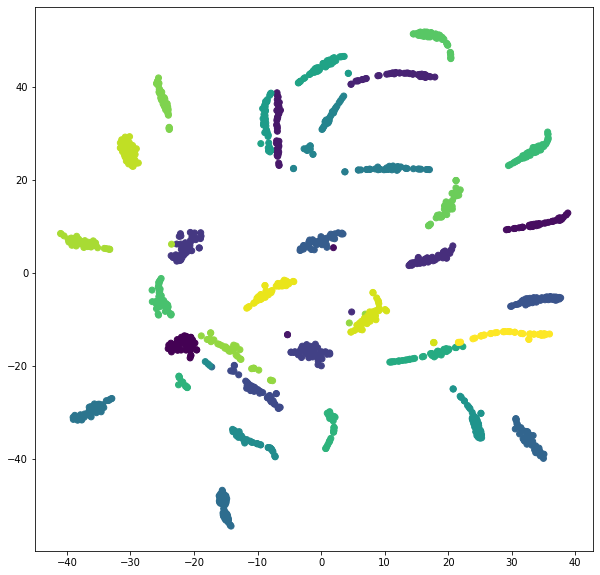

In [93]:
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

colors = [i // 40 for i in range(1280)]
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.scatter(x_axis, y_axis, c = colors)

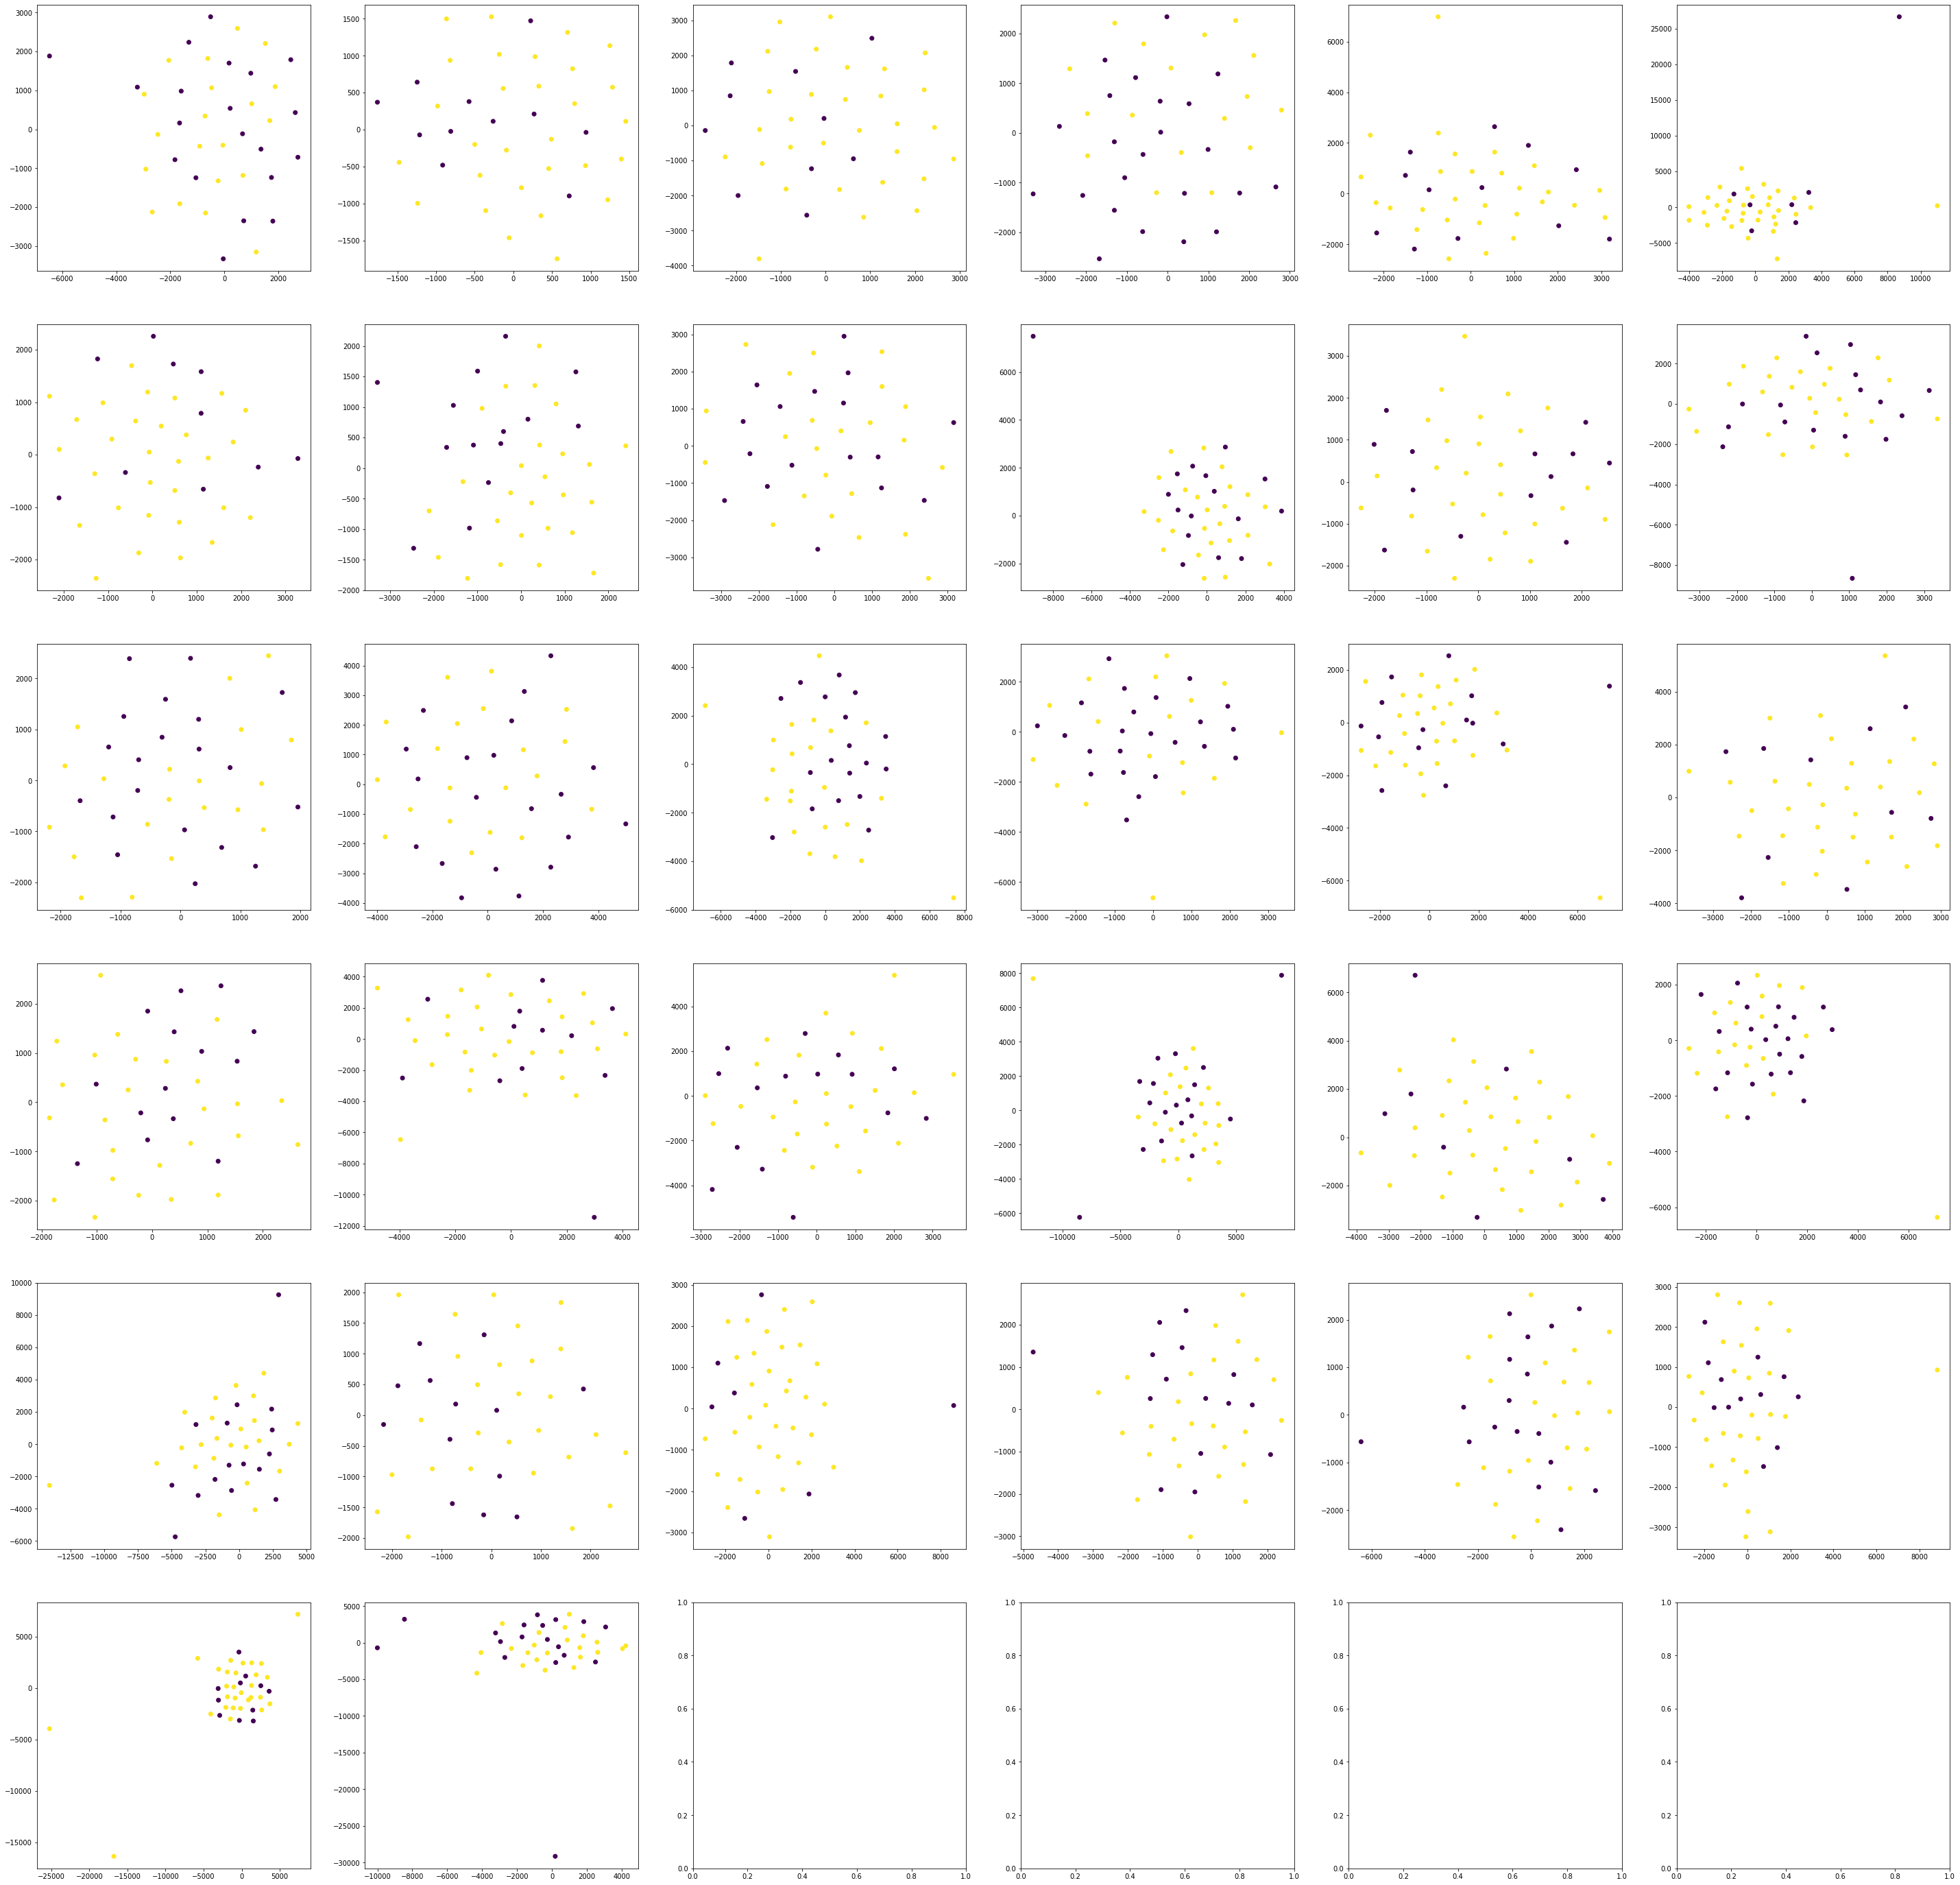

In [123]:
fig, axes = plt.subplots(6, 6, figsize = (50, 50))
for sub in range(32):
    model = TSNE(learning_rate = 1000)
    transformed = model.fit_transform(data_all[sub * 40 : sub * 40 + 40])

    x_axis = transformed[:, 0]
    y_axis = transformed[:, 1]


    colors = labels_all_bin[sub * 40 : sub * 40 + 40, 0]
    #print(colors)
    axes[sub // 6, sub % 6 ].scatter(x_axis, y_axis, c = colors)

In [ ]:
print(labels_all[0])

[7.71 7.6  6.9  7.83]


In [ ]:
threshold = 4.5

In [96]:
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor

In [213]:
import numpy as np
import scipy
from scipy import stats
freq_resolution = max(freq)/(len(freq) - 1)
max_freq = 128
NVIDEOS = 40
NCANALS = 32
def get_features_whole(data, labels, freq_resolution, max_freq):
  data_for_videos = []
  for id in range(NVIDEOS):
    data_for_one_video = []
    for i in range(NCANALS):
        
        freq, power = scipy.signal.welch(data[id][i], fs=max_freq, window='hanning', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
        #one_canal = []
        powers_temp  = []
        for i, interval in enumerate(freq_ranges):
            ar = np.asarray(interval)
            ar = (ar / freq_resolution).astype(int)
            power_range = power[ar]
            mean_power = (power_range ** 2).sum()/len(power_range)
            data_for_one_video.extend([mean_power])
            powers_temp.append(mean_power)
        for s in range(5):
          for k in range(s):
            data_for_one_video.extend([powers_temp[s]/powers_temp[k]])

            
    for pair in pairs_canals:
        canal_1 = pair[0] - 1
        canal_2 = pair[1] - 1
        temp = np.asarray(data_for_one_video[canal_1 * 4 : canal_1 * 4 + 5]) -  np.asarray(data_for_one_video[canal_2 * 4 : canal_2 * 4 + 5])
        data_for_one_video.extend(temp[[0, 2, 3, 4]].tolist())       
        #data_for_one_video.append(one_canal)    
    for s in range(5 * NCANALS):
      data_for_one_video[s] = np.log(data_for_one_video[s])

    temp = np.asarray(data_for_one_video)
    data_for_videos.append(temp.copy())    
    result = np.asarray(data_for_videos)   
    result = stats.zscore(result)
  return np.asarray(data_for_videos)     



In [214]:
data_for_videos = []
for i in  range(len(data)):
    data_for_videos.append(get_features_whole(data[i], labels[i], freq_resolution, max_freq))

data_all = np.vstack(data_for_videos)
labels_all = np.vstack(labels)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [227]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgbm
threshold = 0.5
k = 5
labels_common = []


#for n in range(10, 100, 10):
for i_em in range(4):
    
    labels_common.append([np.mean(labels_all_bin[:, i_em][i::NVIDEOS]) > 0.5 for i in range(NVIDEOS)])
    #print(sum(labels_common[i_em]))
    X = np.arange(40)
    y = np.array(labels_common[i_em])
#print(y)
    #if i_em != 0:
    #  continue

    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    f1_data = pd.DataFrame(columns = range(k), index = range(32))
    acc_data = pd.DataFrame(columns = range(k), index = range(32))
    n = 50
    if i_em == 1:  
      n = 10

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        #model = lgbm.sklearn.LGBMClassifier()
        model =  RandomForestClassifier(50)
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #print(y_train, y_test)
        data_train = []
        data_test = []
        labels_train = []
        labels_test = []
        labels_subject = []
        for j in range(32):
            data_train.append(data_for_videos[j][train_index])
            data_test.append(data_for_videos[j][test_index])
            labels_train.extend(labels_bin[j][:, i_em][train_index])
            labels_test.extend(labels_bin[j][:, i_em][test_index])
            labels_subject.append(labels_bin[j][:, i_em][test_index])
            #print(labels_test[j])
        data_train_all = np.vstack(data_train)
        data_test_all = np.vstack(data_test)   
        model.fit(data_train_all, labels_train)
        labels_predicted = model.predict(data_test_all)
        f1_sub = []
        acc_sub = []
        for i in range(32):
              labels_predicted_sub = model.predict(data_test[i])
              f1_data.loc[i, fold] = (f1_score(labels_predicted_sub, labels_subject[i], average = 'macro'))
              acc_data.loc[i, fold] =  (accuracy_score(labels_predicted_sub, labels_subject[i]))  
    
    print(np.mean(f1_data.values.mean(axis = 1)))
    print(np.mean(acc_data.values.mean(axis = 1)))
                      
                      


0.5373862248862248
0.6625
0.522403117715618
0.66171875
0.5713995379620379
0.68046875
0.5361216214341213
0.68203125


In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgbm
threshold = 0.5
k = 5
labels_common = []


#for n in range(10, 100, 10):
for i_em in range(4):
    
    labels_common.append([np.mean(labels_all_bin[:, i_em][i::NVIDEOS]) > 0.5 for i in range(NVIDEOS)])
    #print(sum(labels_common[i_em]))
    X = np.arange(40)
    y = np.array(labels_common[i_em])
#print(y)
    #if i_em != 0:
    #  continue

    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    f1_data = pd.DataFrame(columns = range(k), index = range(32))
    acc_data = pd.DataFrame(columns = range(k), index = range(32))
    n = 50
    if i_em == 1:  
      n = 10

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        #model = lgbm.sklearn.LGBMClassifier()
        #model =  RandomForestClassifier(50)
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #print(y_train, y_test)
        data_train = []
        data_test = []
        labels_train = []
        labels_test = []
        labels_subject = []
        labels_subject_train = []
        for j in range(32):
            data_train.append(data_for_videos[j][train_index])
            data_test.append(data_for_videos[j][test_index])
            labels_train.extend(labels_bin[j][:, i_em][train_index])
            labels_test.extend(labels_bin[j][:, i_em][test_index])
            labels_subject.append(labels_bin[j][:, i_em][test_index])
            labels_subject_train.append(labels_bin[j][:, i_em][train_index])
            #print(labels_test[j])
        data_train_all = np.vstack(data_train)
        data_test_all = np.vstack(data_test)   
        #model.fit(data_train_all, labels_train)
        #labels_predicted = model.predict(data_test_all)
        f1_sub = []
        acc_sub = []
        for i in range(32):
              model =  RandomForestClassifier(100)
              model.fit(data_train[i],  labels_subject_train[i])#
              labels_predicted_sub = model.predict(data_test[i])
              f1_data.loc[i, fold] = (f1_score(labels_predicted_sub, labels_subject[i], average = 'macro'))
              acc_data.loc[i, fold] =  (accuracy_score(labels_predicted_sub, labels_subject[i]))  
    
    print(np.mean(f1_data.values.mean(axis = 1)))
    print(np.mean(acc_data.values.mean(axis = 1)))

0.5459671578421578
0.6492187500000001
0.5138320360195361
0.6492187500000002
0.5823425879675881
0.6859374999999999


In [ ]:
print(labels_common)

In [ ]:
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor

In [23]:
def process_lca(X, labels, threshold):
  #mask = (labels == 1)
  #print(mask)
  
  X_pos = X[np.array(labels) == 1]# np.asarray([X[i, :] for i in range(NVIDEOS) if labels[i] == 1])
  X_neg = X[np.array(labels) == 0] #np.asarray([X[i, :] for i in range(NVIDEOS) if labels[i] == 0])
  #print(X_pos.shape)
  #print(X_neg.shape)
  ##[X[i, :] if labels[i] == 1 for i in range(NVIDEOS)]
  M1 = np.mean(X_pos, axis = 0)
  M2 = np.mean(X_neg, axis = 0)
  SIG1 = np.std(X_pos, axis = 0)
  SIG2 = np.std(X_neg, axis = 0)
  D = abs(M1 - M2)/(SIG1 ** 2 + SIG2 ** 2)
  #print(X)
  mask =(D > threshold)
  result = X[:, mask]
  return result


Добавляю отбор фич методом LDA ( с порогом 0.3)

In [18]:
def get_features(data, labels, freq_resolution, max_freq):
  data_for_videos = []
  for id in range(NVIDEOS):
    data_for_one_video = []
    for i in range(NCANALS):
        
        freq, power = scipy.signal.welch(data[id][i], fs=max_freq, window='hanning', nperseg=256, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
        #one_canal = []
        powers_temp  = []
        for i, interval in enumerate(freq_ranges):
            ar = np.asarray(interval)
            ar = (ar / freq_resolution).astype(int)
            power_range = power[ar]
            mean_power = (power_range ** 2).sum()#/len(power_range)
            data_for_one_video.extend([mean_power])
            powers_temp.append(mean_power)
        #for s in range(5):
        #  for k in range(s):
        #    data_for_one_video.extend([powers_temp[s]/powers_temp[k]])

            
    for pair in pairs_canals:
        canal_1 = pair[0] - 1
        canal_2 = pair[1] - 1
        temp = np.asarray(data_for_one_video[canal_1 * 4 : canal_1 * 4 + 5]) -  np.asarray(data_for_one_video[canal_2 * 4 : canal_2 * 4 + 5])
        data_for_one_video.extend(temp[[0, 2, 3, 4]].tolist())       
        #data_for_one_video.append(one_canal)    
    for s in range(5 * NCANALS):
      data_for_one_video[s] = np.log(data_for_one_video[s])

    temp = np.asarray(data_for_one_video)
    data_for_videos.append(temp.copy())    
    result = np.asarray(data_for_videos)   
    #result = stats.zscore(result)
  return np.asarray(data_for_videos)     

In [41]:
data_for_videos = []
for i in  range(len(data)):
    data_for_videos.append(get_features(data[i], labels[i], freq_resolution, max_freq))

data_all = np.vstack(data_for_videos)
labels_all = np.vstack(labels)

In [20]:
print(data_all.shape)

(1280, 216)


In [50]:
threshold = 0.4

In [ ]:
import pickle
from sklearn.model_selection import KFold 
from sklearn.naive_bayes import  GaussianNB
from sklearn.model_selection import StratifiedKFold 


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
#define cross-validation method to use
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
cv_like = KFold(n_splits=5, random_state=1, shuffle=True)


acc_valence_all = []
f1_valence_all = []
acc_arousal_all = []
f1_arousal_all = []
acc_like_all = []
f1_like_all = []
for i in  range(len(data)):
    #print(i)
    #data_for_videos = get_features(data[i], labels[i], freq_resolution, max_freq)
    X = data_for_videos[i]
    y_valence = [1 if l > 4.5 else 0 for l in labels[i][:, 0]]
    y_arousal = [1 if l > 4.5 else 0 for l in labels[i][:, 1]]
    y_like = [1 if l > 4.5 else 0 for l in labels[i][:, 3]]
    #print(y_like)
    #print(y_valence)
    #print(y_arousal)
    #print(y_like)
    X_valence = process_lca(X, y_valence, threshold)
    X_arousal = process_lca(X, y_arousal, threshold)
    X_like = process_lca(X, y_like, threshold)
    # print(X_valence.shape)
    # print(X_arousal.shape)
    # print(X_like.shape)
    
    
    model = GaussianNB()
    #use k-fold CV to evaluate model
    scores_f1 = cross_val_score(model, X_valence, y_valence, cv=cv, scoring = 'f1_macro', n_jobs=-1)
    #print(scores_f1)

    f1_valence_all.append((np.mean(scores_f1), np.std(scores_f1)))
    model = GaussianNB()
    scores_acc = cross_val_score(model, X_valence, y_valence, cv=cv, scoring = 'accuracy', n_jobs=-1)
    #print(scores_acc)
    acc_valence_all.append((np.mean(scores_acc), np.std(scores_acc)))
    model = GaussianNB()
    # #use k-fold CV to evaluate model
    scores_f1 = cross_val_score(model, X_arousal, y_arousal, cv=cv, scoring = 'f1_macro', n_jobs=-1)
    #print(scores_f1)
    f1_arousal_all.append((np.mean(scores_f1), np.std(scores_f1)))
    scores_acc = cross_val_score(model, X_arousal, y_arousal, cv=cv, scoring = 'accuracy', n_jobs=-1)
    #print(scores_acc)
    acc_arousal_all.append((np.mean(scores_acc),np.std(scores_acc)))
    
    model = GaussianNB()
    # # #model = KNeighborsClassifier(n_neighbors=2) 
    # # #use k-fold CV to evaluate model
    scores_f1 = cross_val_score(model, X_like, y_like, cv=cv_like, scoring = 'f1_macro', n_jobs=-1)
    print(scores_f1)
    f1_like_all.append((np.mean(scores_f1), np.std(scores_acc)))
    scores_acc = cross_val_score(model, X_like, y_like, cv=cv_like, scoring = 'accuracy', n_jobs=-1)
    #print(scores_acc)
    acc_like_all.append((np.mean(scores_acc), np.std(scores_acc)))

In [ ]:
result = pd.concat((pd.DataFrame(f1_valence_all, columns = ['val_f1_mean', 'val_f1_std']),pd.DataFrame(acc_valence_all, columns = ['val_acc_mean', 'val_acc_std'])), axis = 1)
result = pd.concat((result, pd.DataFrame(f1_arousal_all, columns = ['arousal_f1_mean', 'arousal_f1_std']),pd.DataFrame(acc_arousal_all, columns = ['arousal_acc_mean', 'arousal_acc_std'])), axis = 1)
result = pd.concat((result, pd.DataFrame(f1_like_all, columns = ['like_f1_mean', 'like_f1_std']),pd.DataFrame(acc_like_all, columns = ['like_acc_mean', 'like_acc_std'])), axis = 1)
print(result)



In [85]:
print(result.mean(axis = 0))

val_f1_mean         0.600704
val_f1_std          0.136356
val_acc_mean        0.657813
val_acc_std         0.130308
arousal_f1_mean     0.578687
arousal_f1_std      0.152470
arousal_acc_mean    0.659375
arousal_acc_std     0.135790
like_f1_mean        0.612761
like_f1_std         0.135790
like_acc_mean       0.698276
like_acc_std        0.142453
dtype: float64


(array([ 4.,  3.,  2., 10.,  6.,  3.,  1.,  1.,  1.,  1.]),
 array([0.575 , 0.5975, 0.62  , 0.6425, 0.665 , 0.6875, 0.71  , 0.7325,
        0.755 , 0.7775, 0.8   ]),
 <a list of 10 Patch objects>)

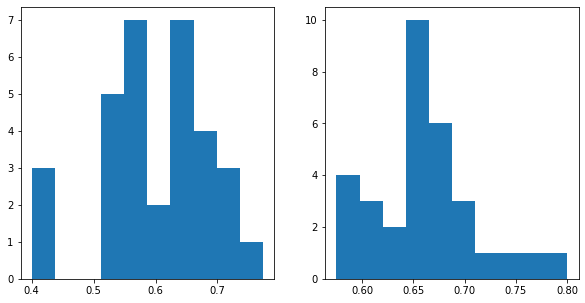

In [89]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].hist(result['val_f1_mean'])
axes[1].hist(result['val_acc_mean'])



(array([ 1.,  1.,  3.,  3., 11.,  5.,  3.,  2.,  2.,  1.]),
 array([0.45  , 0.4925, 0.535 , 0.5775, 0.62  , 0.6625, 0.705 , 0.7475,
        0.79  , 0.8325, 0.875 ]),
 <a list of 10 Patch objects>)

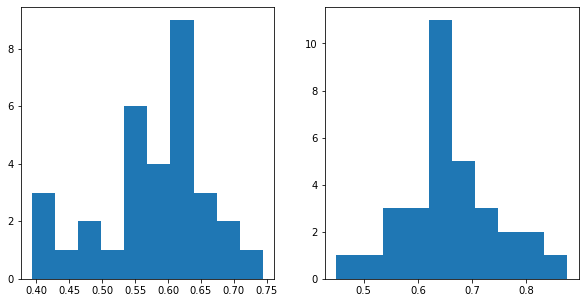

In [90]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].hist(result['arousal_f1_mean'])
axes[1].hist(result['arousal_acc_mean'])

(array([1., 3., 4., 9., 1., 4., 3., 1., 1., 2.]),
 array([0.5  , 0.545, 0.59 , 0.635, 0.68 , 0.725, 0.77 , 0.815, 0.86 ,
        0.905, 0.95 ]),
 <a list of 10 Patch objects>)

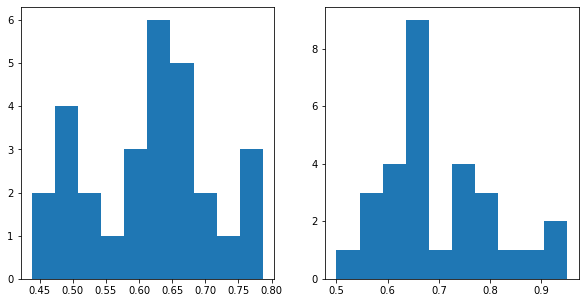

In [91]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].hist(result['like_f1_mean'])
axes[1].hist(result['like_acc_mean'])

In [127]:
pd.set_option('max_columns', None)
print(result)

    val_f1_mean  val_f1_std  val_acc_mean  val_acc_std  arousal_f1_mean  \
0      0.645238    0.168949         0.650     0.165831         0.657013   
1      0.514033    0.209136         0.650     0.165831         0.526984   
2      0.551096    0.236232         0.625     0.209165         0.606061   
3      0.671429    0.064153         0.675     0.061237         0.405758   
4      0.547399    0.158904         0.650     0.093541         0.538470   
5      0.407082    0.027035         0.650     0.145774         0.567302   
6      0.535584    0.140865         0.650     0.093541         0.617489   
7      0.576317    0.140173         0.650     0.093541         0.412063   
8      0.680952    0.232982         0.700     0.231840         0.652867   
9      0.558095    0.177124         0.575     0.169558         0.558788   
10     0.604473    0.144153         0.625     0.136931         0.619394   
11     0.583362    0.125181         0.600     0.122474         0.565714   
12     0.707807    0.1080

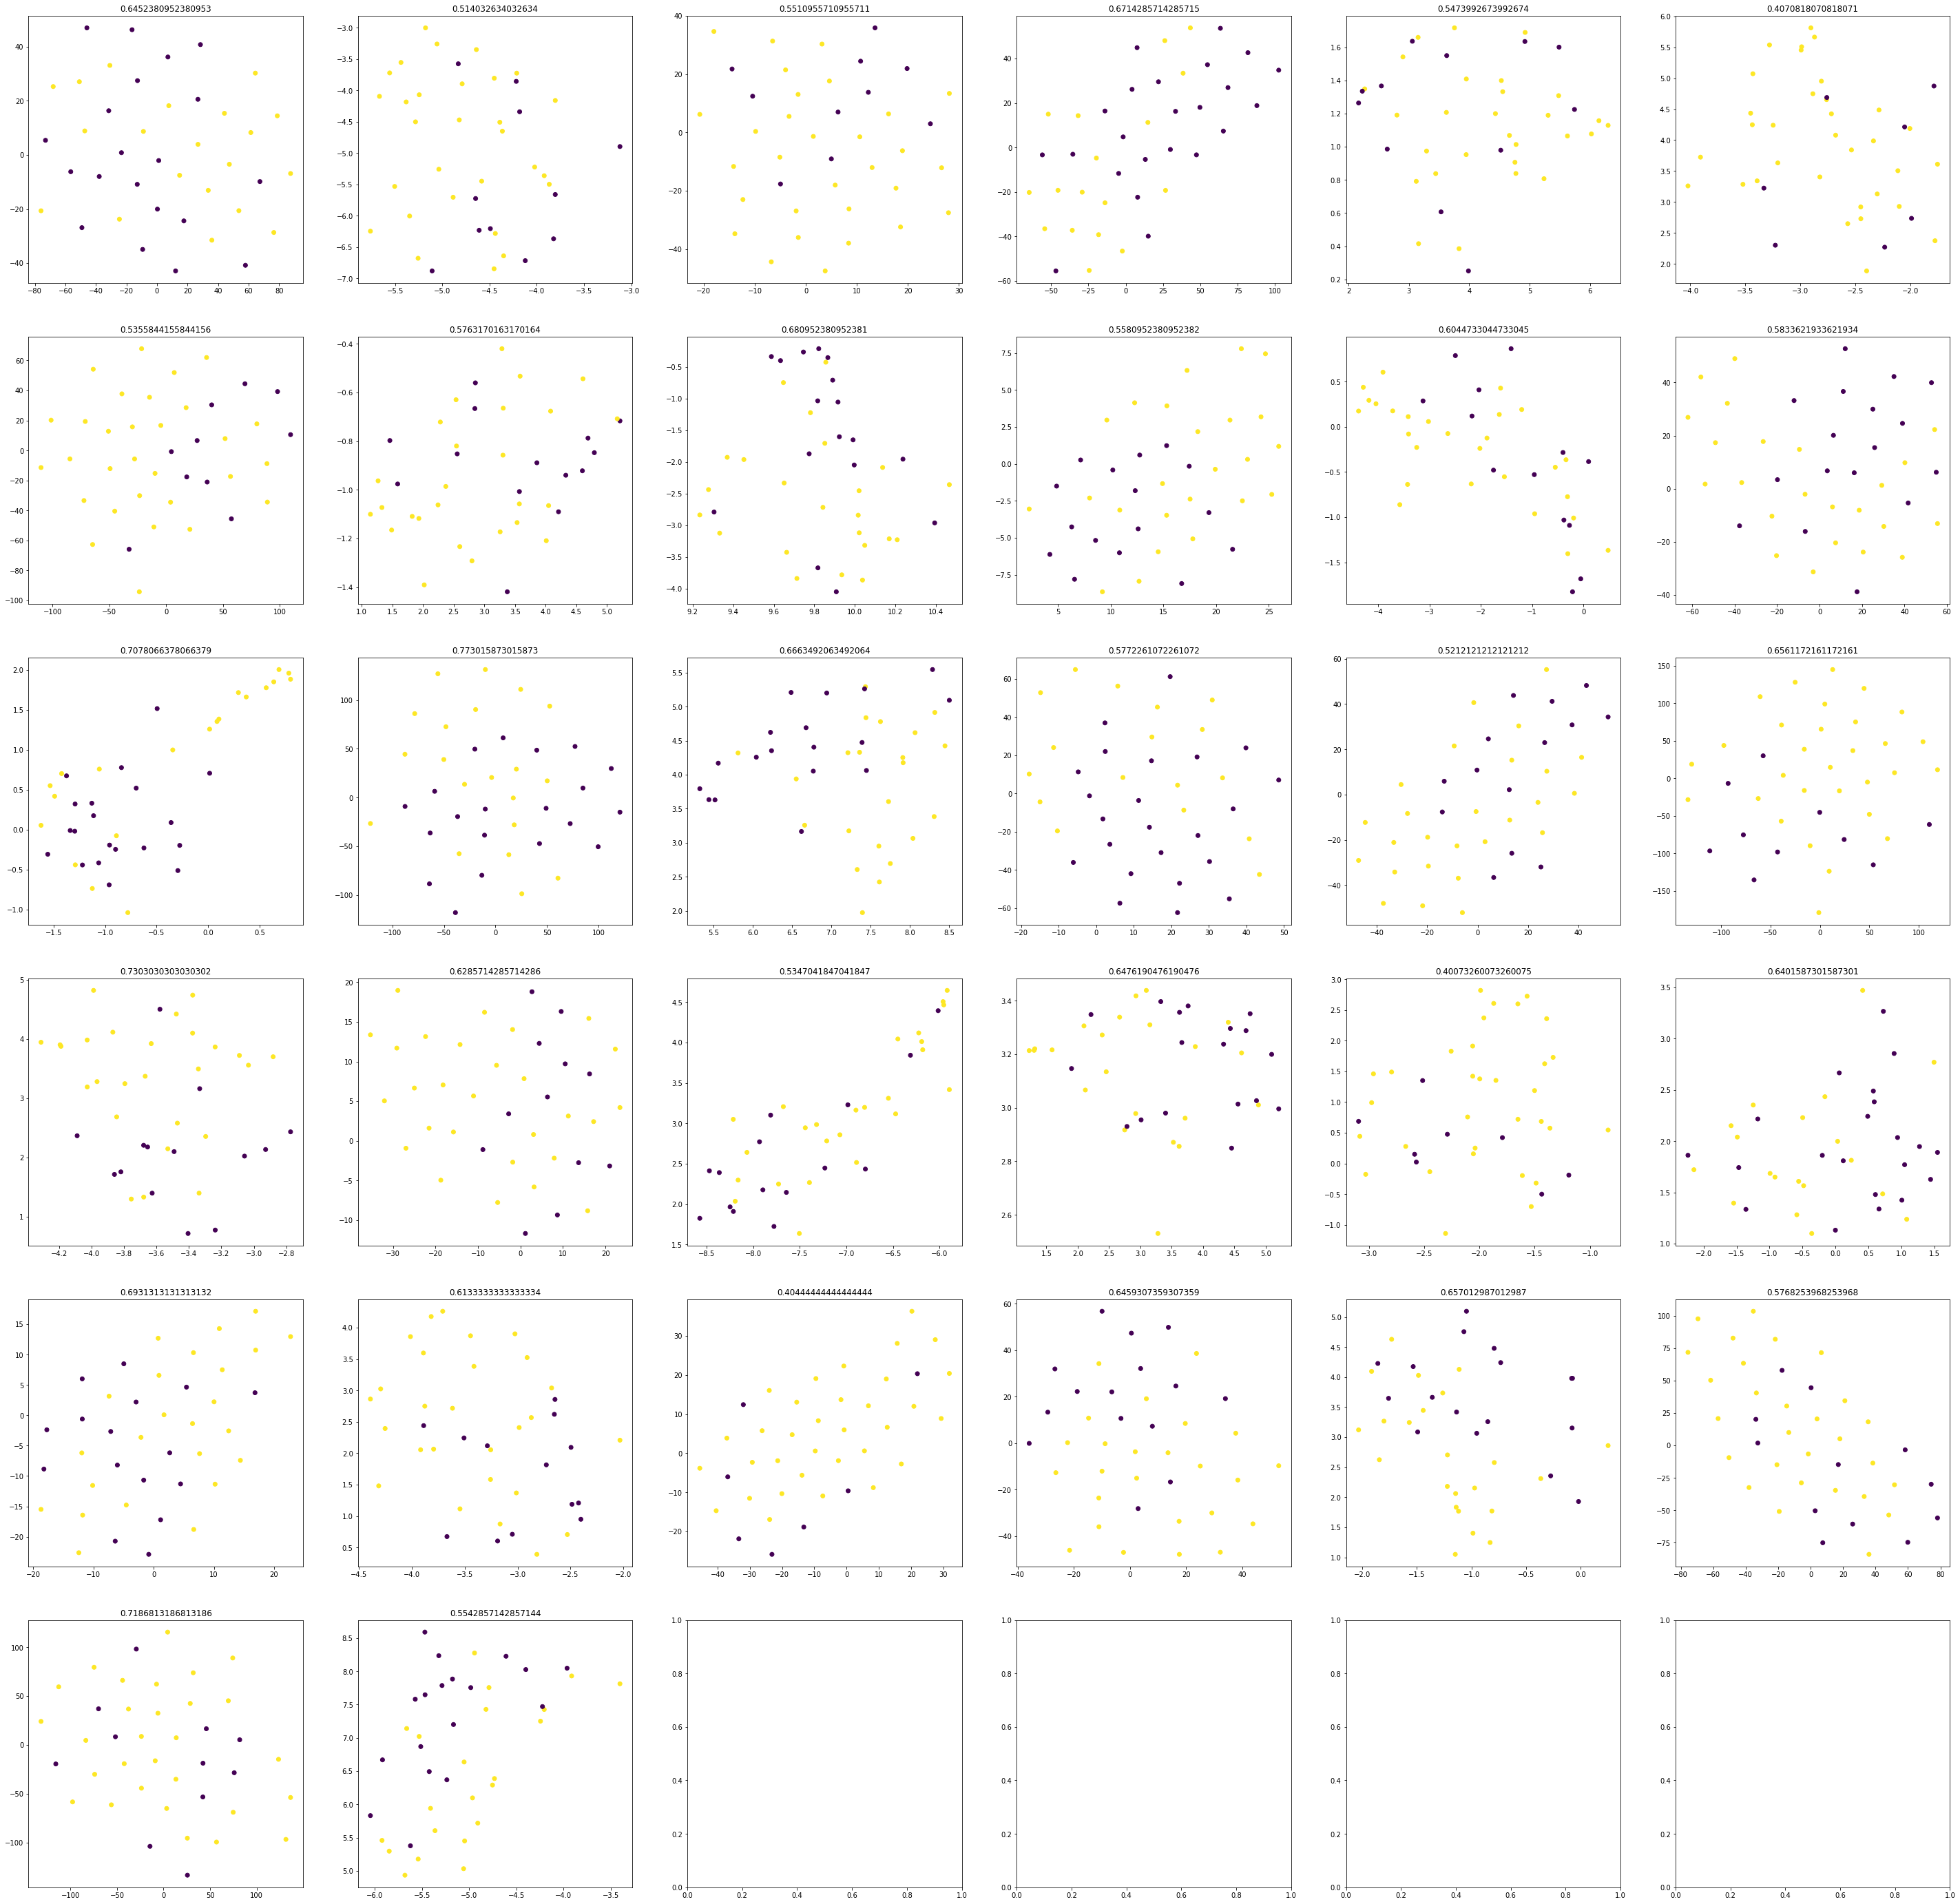

In [109]:
from sklearn.manifold import TSNE
acc_valence_all = []
f1_valence_all = []
acc_arousal_all = []
f1_arousal_all = []
acc_like_all = []
f1_like_all = []

fig, axes = plt.subplots(6, 6, figsize = (50, 50))
for i in  range(32):
    #print(i)
    #data_for_videos = get_features(data[i], labels[i], freq_resolution, max_freq)
    X = data_for_videos[i]
    y_valence = [1 if l > 4.5 else 0 for l in labels[i][:, 0]]
    #y_arousal = [1 if l > 4.5 else 0 for l in labels[i][:, 1]]
    #y_like = [1 if l > 4.5 else 0 for l in labels[i][:, 3]]
    #print(y_like)
    #print(y_valence)
    #print(y_arousal)
    #print(y_like)
    X_valence = process_lca(X, y_valence, threshold)
    #X_arousal = process_lca(X, y_arousal, threshold)
    #X_like = process_lca(X, y_like, threshold)


    model = TSNE(learning_rate = 100)
    transformed = model.fit_transform(X_valence)

    x_axis = transformed[:, 0]
    y_axis = transformed[:, 1]


    colors = y_valence
    #print(colors)
    title = f"{result.loc[i, 'val_f1_mean']}"
    axes[i // 6, i % 6 ].scatter(x_axis, y_axis, c = colors)
    axes[i // 6, i % 6 ].set_title(title)





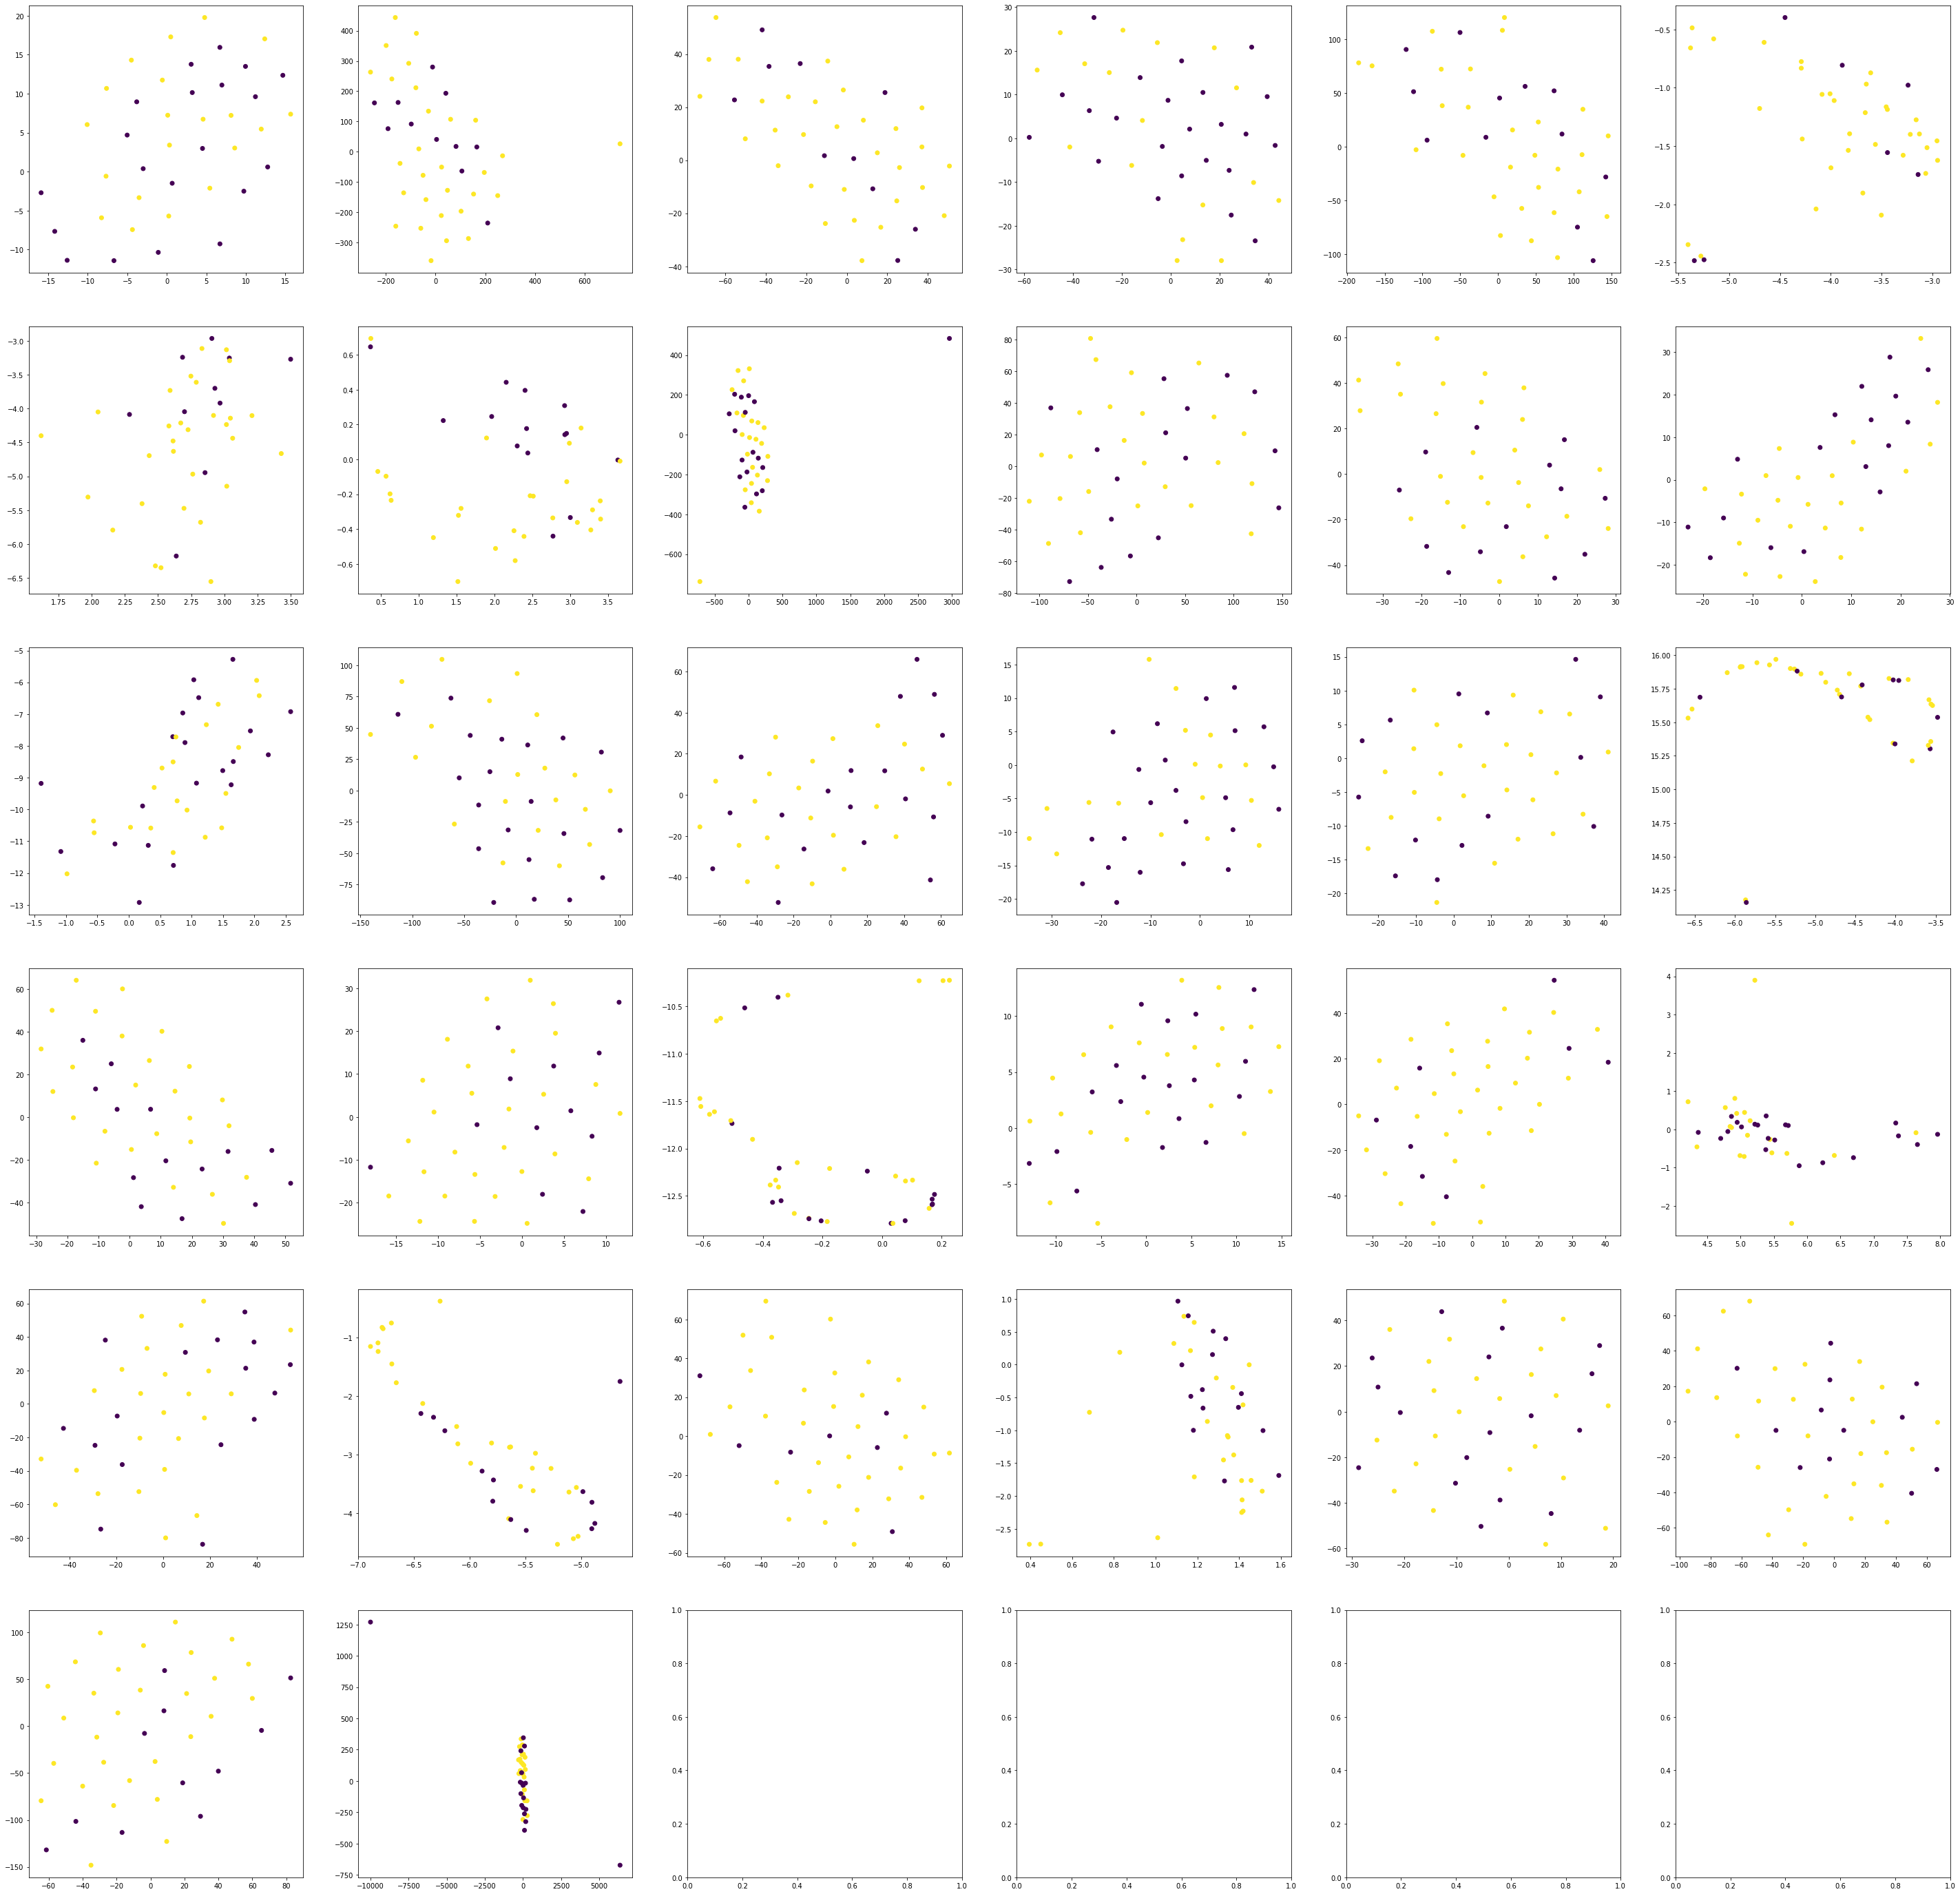

In [102]:
from sklearn.manifold import TSNE
acc_valence_all = []
f1_valence_all = []
acc_arousal_all = []
f1_arousal_all = []
acc_like_all = []
f1_like_all = []

fig, axes = plt.subplots(6, 6, figsize = (50, 50))
for i in  range(32):
    model = TSNE(learning_rate = 100)
    transformed = model.fit_transform(data_for_videos[i])

    x_axis = transformed[:, 0]
    y_axis = transformed[:, 1]


    colors = labels_all_bin[i * 40 : i * 40 + 40, 0]
    #print(colors)
    axes[i // 6, i % 6 ].scatter(x_axis, y_axis, c = colors)

In [125]:
for i in  range(1):
    X = data_for_videos[i]
    y_valence = [1 if l > 4.5 else 0 for l in labels[i][:, 0]]
    X_valence = process_lca(X, y_valence, 0.6)
    print(X_valence.shape)

    

(40, 7)


In [121]:
print(type(X_valence))
print(y_valence)

<class 'numpy.ndarray'>
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


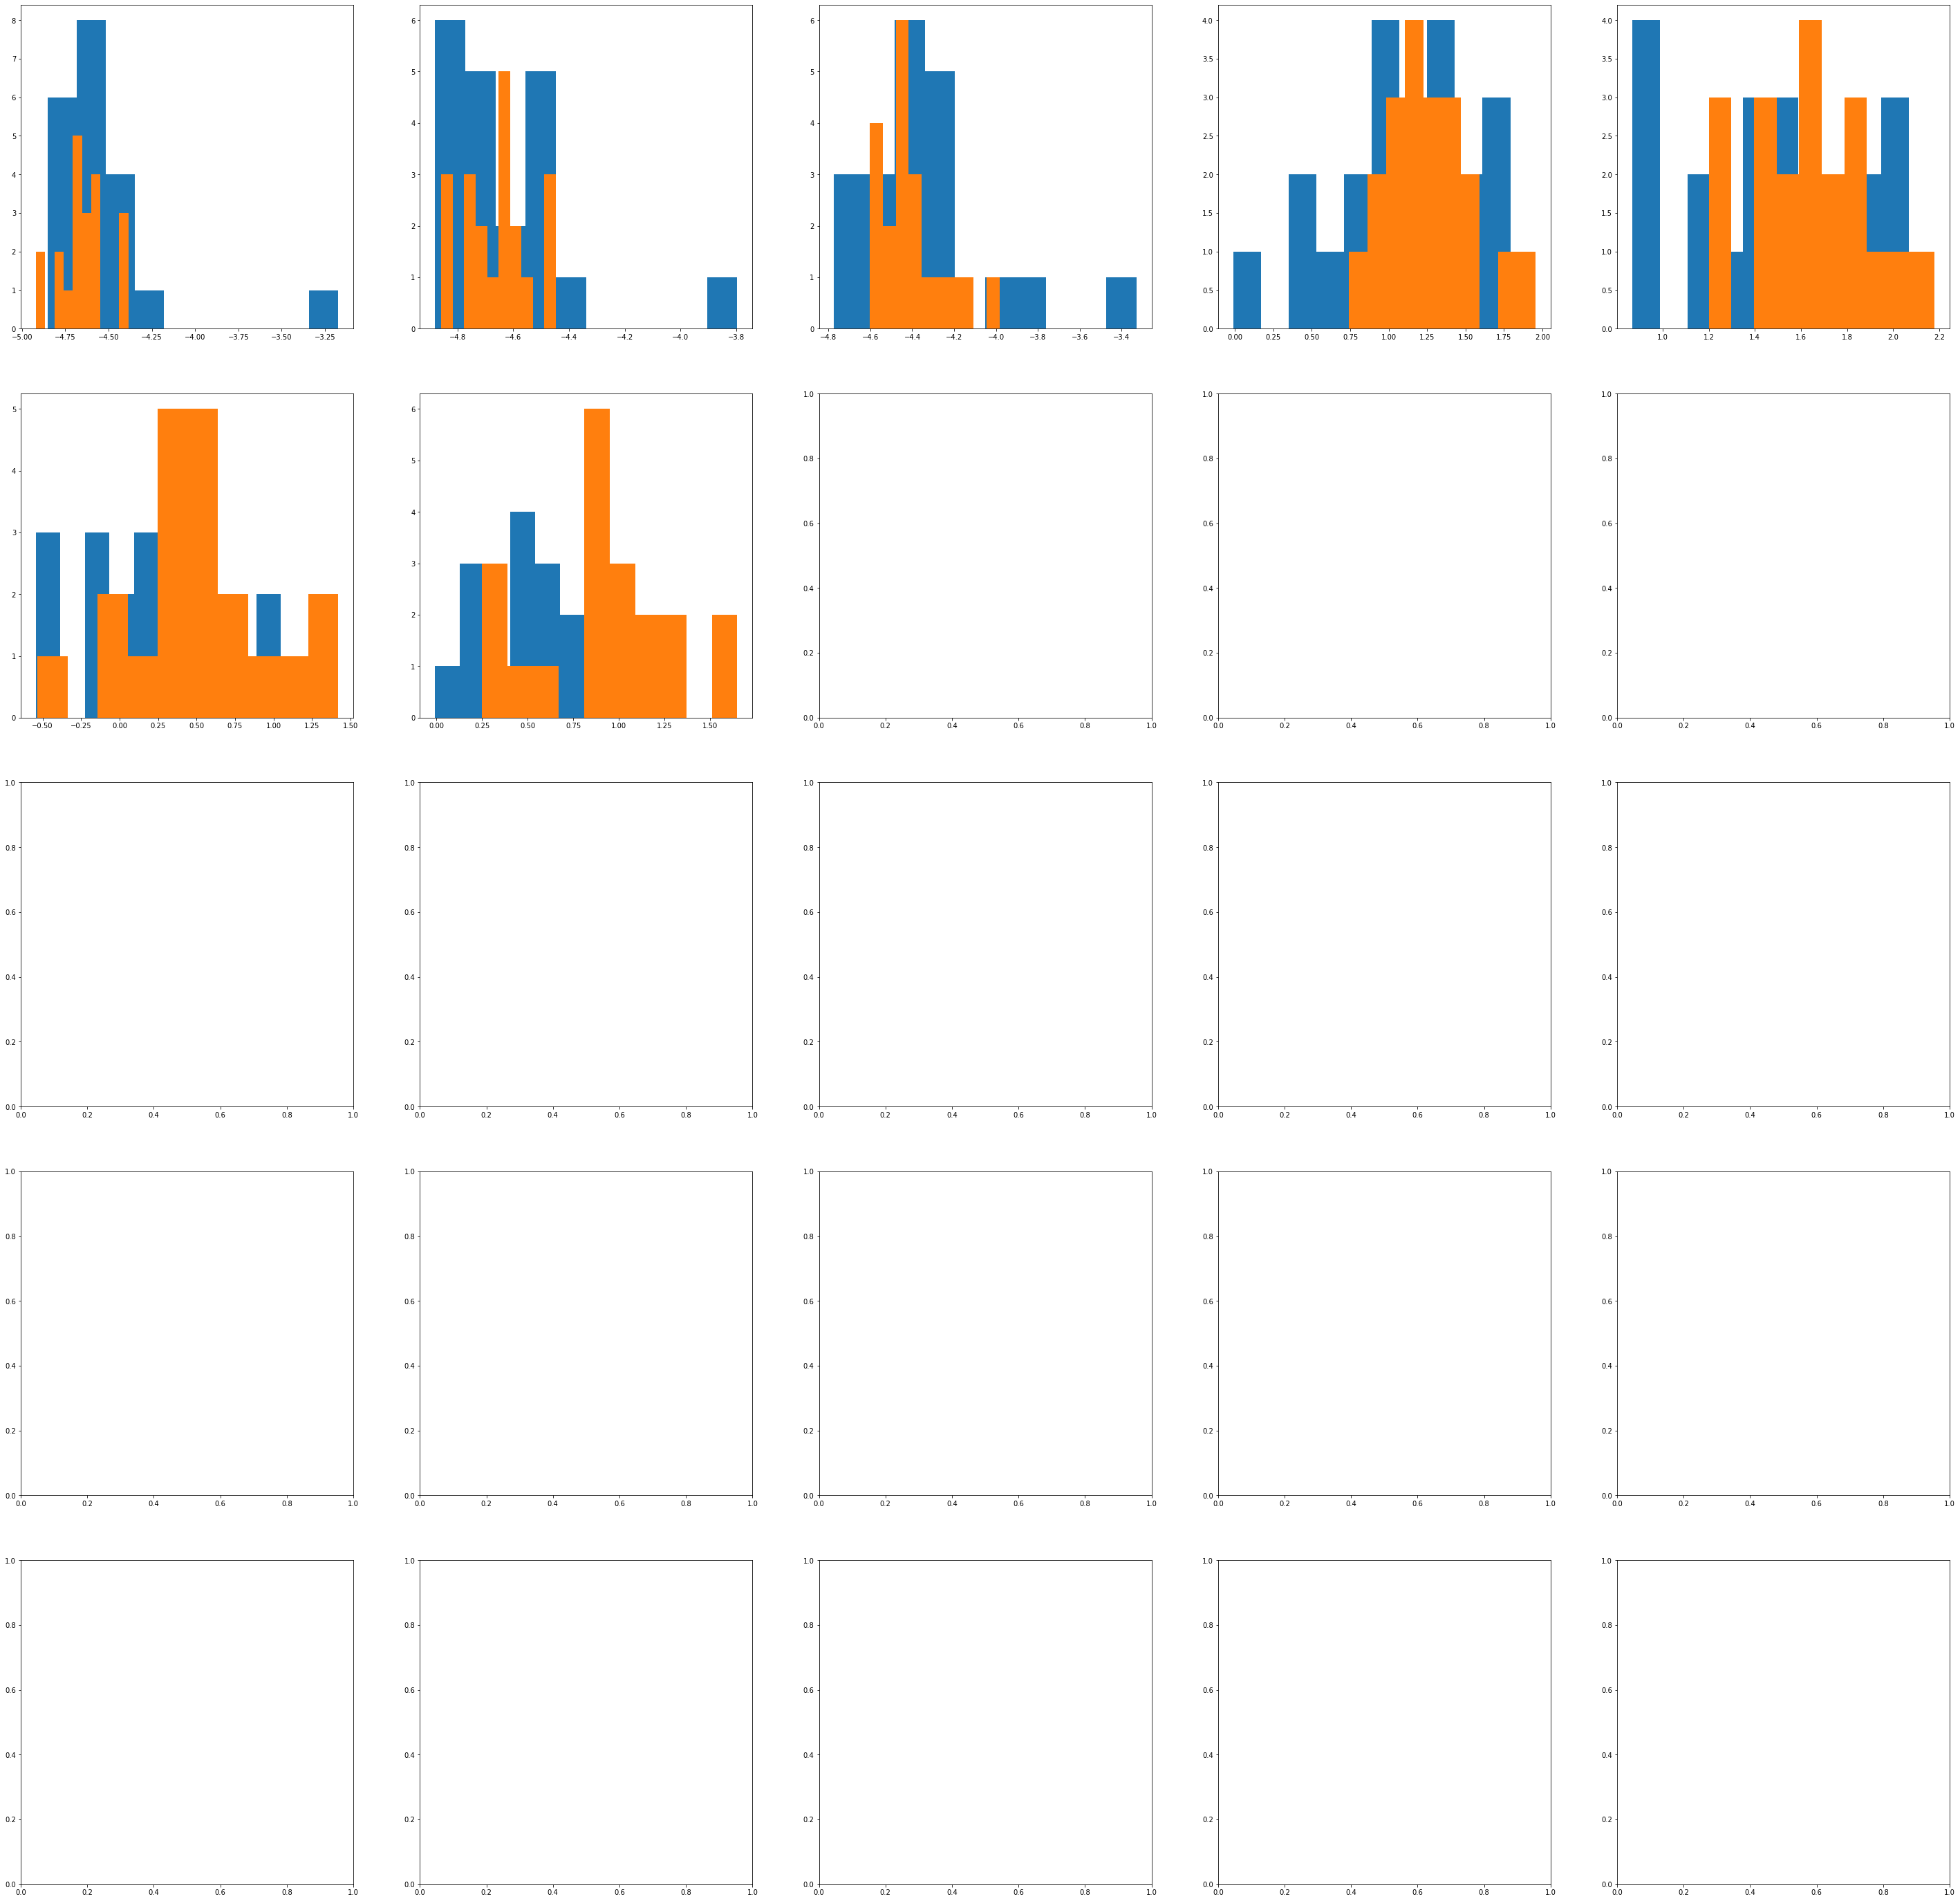

In [126]:
fig, axes = plt.subplots(5, 5, figsize = (50, 50))
for i in range(X_valence.shape[1]):
     mask = np.array(y_valence)
     axes[i // 5, i % 5 ].hist(X_valence[mask == 1, i])  
     axes[i // 5, i % 5 ].hist(X_valence[mask == 0, i])  
